# **Setup**

**Block 1: Master Setup & Data Loading**

Initializes the project environment by installing dependencies and importing necessary libraries. It also downloads the dataset from Kaggle and verifies that the image files are correctly loaded and ready for use.

In [1]:
# --- BLOCK 1: MASTER SETUP (IMPORTS & DATASET) ---

# 1. Install YOLO Library (Check if missing)
try:
    import ultralytics
except ImportError:
    print("⬇️ Installing Ultralytics YOLO library...")
    !pip install ultralytics -q

# 2. Import All Required Libraries for the Entire Project
import os
import glob
import shutil
import random
import time
import yaml
import kagglehub
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import torch
from google.colab import drive
from datetime import datetime
from collections import Counter
import csv
from ultralytics import YOLO
from IPython.display import Image, display


print("✅ All libraries imported successfully.")

# 3. Download Dataset via KaggleHub
print("⬇️ Downloading dataset...")
# This function returns the specific path where the files were saved
dataset_path = kagglehub.dataset_download("amiranmkrtchyan/amiran")

print(f"✅ Dataset downloaded to: {dataset_path}")

# 4. Verify Images Exist
image_files = []
# Search recursively for images (supports jpg, jpeg, png)
for ext in ["*.jpg", "*.jpeg", "*.png"]:
    image_files.extend(glob.glob(os.path.join(dataset_path, "**", ext), recursive=True))

if len(image_files) == 0:
    print("❌ ERROR: No images found. Check the download path.")
else:
    print(f"✅ SUCCESS: Found {len(image_files)} images ready for processing.")
    print(f"   Example path: {image_files[0]}")

⬇️ Installing Ultralytics YOLO library...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ All libraries imported successfully.
⬇️ Downloading dataset...
Using Colab cache for faster access to the 'amiran' dataset.
✅ Dataset downloaded to: /kaggle/input/amiran
✅ SUCCESS: Found 4413 images ready for processing.
   Example path: /kaggle/input/amiran/all_fields_lincolnbeet/all/near30_near30_21_05_2021_v_7_161.png


**Block 2: Ground Truth Parser**

Parses the XML annotation files to extract the correct bounding box coordinates (xmin, ymin, xmax, ymax) for each image. These values serve as the reference "Ground Truth" for evaluating the models.

In [2]:
# --- BLOCK 2: GROUND TRUTH PARSING (XML) ---

def get_ground_truth_boxes(xml_path):
    """
    Parses the XML file to extract bounding boxes for all objects.
    Returns a list of boxes in format: [xmin, ymin, xmax, ymax]
    """
    if not os.path.exists(xml_path):
        return []

    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))

        boxes.append([xmin, ymin, xmax, ymax])

    return boxes

print("✅ XML Parsing function defined.")

✅ XML Parsing function defined.


# **Classical**

**Block 3: Classical Detection Pipeline**

Defines the classical image processing logic. It segments plants from the background using the Excess Green (ExG) index and Otsu’s thresholding, refines the mask via morphological operations, and converts detected contours into bounding boxes for object localization.

In [12]:
# --- BLOCK 3: CLASSICAL DETECTION PIPELINE ---

def detect_objects_classic(img_rgb):
    """
    Detects plants using classical Computer Vision techniques:
    1. Excess Green (ExG) Index calculation.
    2. Otsu's Thresholding.
    3. Morphological Closing and Opening.
    4. Contour detection -> Bounding Boxes.
    """
    # 1. Calculate ExG (Excess Green)
    r, g, b = cv2.split(img_rgb.astype("float"))
    exg = 2 * g - r - b
    exg_norm = cv2.normalize(exg, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

    # 2. Otsu Thresholding
    # Automatically finds the optimal separation value [Source: Otsu's Method]
    _, binary_mask = cv2.threshold(exg_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Morphological Operations
    # Closing to fill holes, Opening to remove noise [Source: Dilation/Erosion]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    # 4. Find Contours and convert to Bounding Boxes
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_boxes = []
    min_area = 300 # Filter out small noise

    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            # Format: [xmin, ymin, xmax, ymax]
            detected_boxes.append([x, y, x + w, y + h])

    return detected_boxes, mask_clean

print("✅ Classical Detection Pipeline defined.")

✅ Classical Detection Pipeline defined.


**Block 4: IoU Metric Calculation**

Implements the Intersection over Union (IoU) function to quantify detection accuracy by measuring the mathematical overlap between the predicted box and the ground truth.

*Score Interpretation:*

 0: No overlap (Failure).

 1: Perfect match (Success).


In [13]:
# --- BLOCK 4: METRICS CALCULATION (IoU) ---

def calculate_iou(boxA, boxB):
    """
    Calculates Intersection over Union (IoU) between two boxes.
    Box format: [xmin, ymin, xmax, ymax]
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    epsilon = 1e-5 # To prevent division by zero
    iou = interArea / float(boxAArea + boxBArea - interArea + epsilon)

    return iou

print("✅ IoU Calculation function defined.")

✅ IoU Calculation function defined.


**Block 5: Classical Pipeline Evaluation & Visualization**

Executes the classical detection logic on a test image and compares the results against the Ground Truth XML. It computes comprehensive pixel-based metrics (IoU, Accuracy, Precision, Recall, Specificity) and generates a 5-panel visualization to diagnose performance:

1) Original Image: The raw input image.

2) GT Mask: The reference mask derived from XML data (Ground Truth).

3) Prediction Mask: The binary output produced by the classical algorithm.

4) Error Map: A pixel-level diagnostic heatmap (Green=Correct, Red=False Positive, Blue=Missed).

5) Bounding Boxes: Final comparison showing Ground Truth (Green) vs. Predictions (Red).

📸 Testing on Image: near30_near30_14_05_2021_v_1_56.png

📊 FINAL CLASSICAL METRICS (Pixel-Based):
   • IoU Score:    0.2286
   • Accuracy:     0.9935
   • Precision:    1.0000
   • Recall:       0.2286
   • Specificity:  1.0000
------------------------------
   • Detected Objects: 3
   • Ground Truth Objects: 2


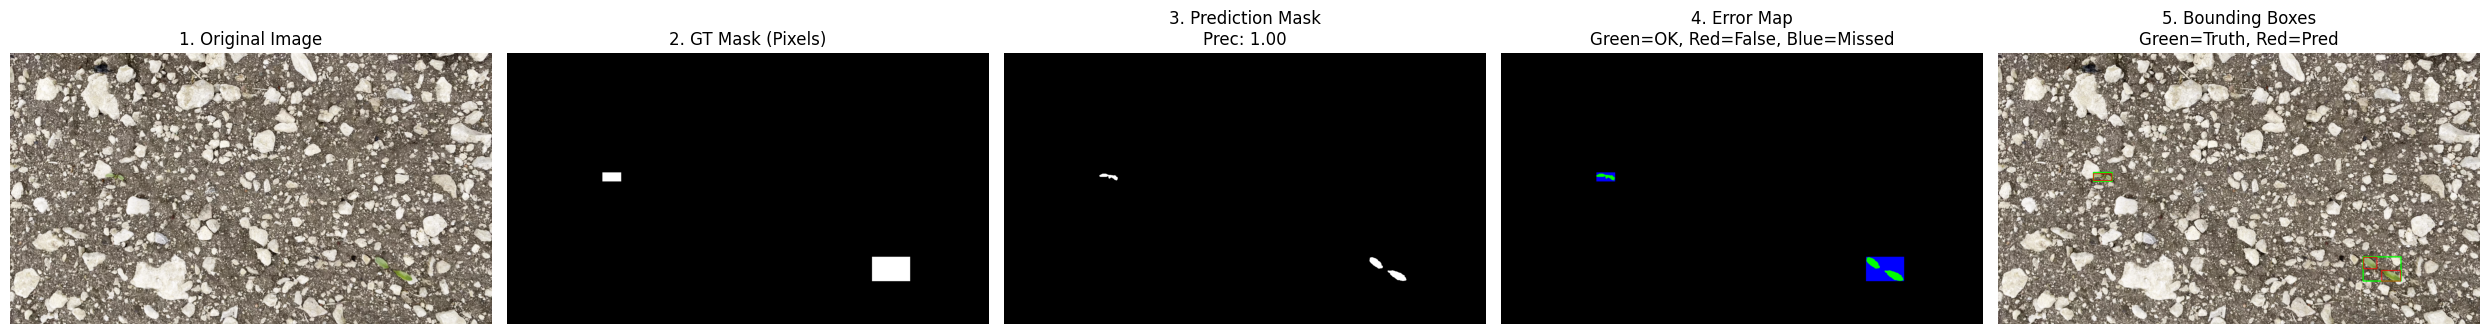

In [14]:
# --- BLOCK 5: CLASSICAL EVALUATION (ALL METRICS + 5 VISUALS) ---

# 1. Verification
if 'image_files' not in locals() or len(image_files) == 0:
    print("❌ ERROR: No images found. Please run Block 1 (Master Setup) again.")
else:
    # 2. Select Image
    target_index = 100 if len(image_files) > 100 else 0
    target_img_path = image_files[target_index]

    # Construct XML path
    base_name = os.path.splitext(target_img_path)[0]
    xml_path = base_name + ".xml"

    print(f"📸 Testing on Image: {os.path.basename(target_img_path)}")

    # 3. Process Only if XML Exists
    if os.path.exists(xml_path):
        # Load Image
        img = cv2.imread(target_img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Check for Helper Functions
        if 'detect_objects_classic' not in locals() or 'get_ground_truth_boxes' not in locals():
            print("❌ ERROR: Helper functions missing. Please re-run Blocks 2 & 3.")
        else:
            # --- A. GET PREDICTIONS ---
            predicted_boxes, binary_mask = detect_objects_classic(img_rgb)

            # --- B. CREATE GROUND TRUTH MASK ---
            gt_mask = np.zeros_like(binary_mask)
            gt_boxes = get_ground_truth_boxes(xml_path)

            for box in gt_boxes:
                cv2.rectangle(gt_mask, (box[0], box[1]), (box[2], box[3]), 255, -1)

            # --- C. CALCULATE METRICS (PIXEL-BASED) ---
            y_true = (gt_mask / 255).astype(int).flatten()
            y_pred = (binary_mask / 255).astype(int).flatten()

            TP = np.sum((y_true == 1) & (y_pred == 1))
            TN = np.sum((y_true == 0) & (y_pred == 0))
            FP = np.sum((y_true == 0) & (y_pred == 1))
            FN = np.sum((y_true == 1) & (y_pred == 0))

            epsilon = 1e-7
            accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
            precision = TP / (TP + FP + epsilon)
            recall = TP / (TP + FN + epsilon)
            specificity = TN / (TN + FP + epsilon)

            # IoU calculation
            intersection = TP
            union = TP + FP + FN
            iou = intersection / (union + epsilon)

            # --- D. PREPARE BOUNDING BOX IMAGE (THE 5TH IMAGE) ---
            vis_box_img = img_rgb.copy()
            # Draw Ground Truth (GREEN)
            for box in gt_boxes:
                cv2.rectangle(vis_box_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 3)
            # Draw Predictions (RED)
            for box in predicted_boxes:
                cv2.rectangle(vis_box_img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

            # --- E. OUTPUT RESULTS ---
            print("\n📊 FINAL CLASSICAL METRICS (Pixel-Based):")
            print(f"   • IoU Score:    {iou:.4f}")
            print(f"   • Accuracy:     {accuracy:.4f}")
            print(f"   • Precision:    {precision:.4f}")
            print(f"   • Recall:       {recall:.4f}")
            print(f"   • Specificity:  {specificity:.4f}")
            print("-" * 30)
            print(f"   • Detected Objects: {len(predicted_boxes)}")
            print(f"   • Ground Truth Objects: {len(gt_boxes)}")

            # --- F. VISUALIZATION (5 PANELS) ---
            plt.figure(figsize=(25, 5))

            # 1. Original
            plt.subplot(1, 5, 1)
            plt.imshow(img_rgb)
            plt.title("1. Original Image")
            plt.axis('off')

            # 2. Ground Truth Mask
            plt.subplot(1, 5, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("2. GT Mask (Pixels)")
            plt.axis('off')

            # 3. Prediction Mask
            plt.subplot(1, 5, 3)
            plt.imshow(binary_mask, cmap='gray')
            plt.title(f"3. Prediction Mask\nPrec: {precision:.2f}")
            plt.axis('off')

            # 4. Error Map
            error_map = np.zeros_like(img_rgb)
            error_map[(gt_mask == 255) & (binary_mask == 255)] = [0, 255, 0] # TP
            error_map[(gt_mask == 0) & (binary_mask == 255)] = [255, 0, 0]   # FP
            error_map[(gt_mask == 255) & (binary_mask == 0)] = [0, 0, 255]   # FN
            plt.subplot(1, 5, 4)
            plt.imshow(error_map)
            plt.title("4. Error Map\nGreen=OK, Red=False, Blue=Missed")
            plt.axis('off')

            # 5. Bounding Boxes (Comparison)
            plt.subplot(1, 5, 5)
            plt.imshow(vis_box_img)
            plt.title("5. Bounding Boxes\nGreen=Truth, Red=Pred")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    else:
        print(f"⚠️ XML file not found at: {xml_path}")

# **YOLO**

**Block 1 (YOLO): Directory Setup & Class Mapping**

Establishes the directory structure required for YOLO segmentation training by creating separate folders for images and labels (split into train/val). It also defines the CLASS_MAPPING dictionary to convert text labels into the integer IDs required by the model (0=Sugar Beet, 1=Weed).

In [3]:
# --- BLOCK 1 (YOLO SEG): DIRECTORY SETUP & CLASS MAPPING ---

# 1. Define Output Directory for Segmentation
output_dir = "yolo_seg_dataset"

# 2. Define sub-directories structure
dirs_to_create = [
    os.path.join(output_dir, "images", "train"),
    os.path.join(output_dir, "images", "val"),
    os.path.join(output_dir, "labels", "train"),
    os.path.join(output_dir, "labels", "val")
]

# 3. Create Directories
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

# 4. Define Class Mapping
# YOLO requires integer IDs.
# 0 = Sugar Beet (Crop), 1 = Weed
CLASS_MAPPING = {
    "sugarbeet": 0,
    "crop": 0,
    "weed": 1
}

print(f"✅ Segmentation directory structure created at: {os.path.abspath(output_dir)}")
print(f"✅ Class mapping defined: {CLASS_MAPPING}")

✅ Segmentation directory structure created at: /content/yolo_seg_dataset
✅ Class mapping defined: {'sugarbeet': 0, 'crop': 0, 'weed': 1}


**Block 2: Polygon Conversion Logic**

Converts standard bounding box coordinates from the XML files into the normalized polygon format required by YOLO Segmentation. Since the raw data only provides boxes, this function defines the polygon as a 4-point rectangle, scaling the corner coordinates to the 0-1 range expected by the model.

In [4]:
# --- BLOCK 2: POLYGON CONVERSION LOGIC ---

def convert_box_to_polygon_str(size, box):
    """
    Converts a Bounding Box (xmin, ymin, xmax, ymax) into a Polygon string.
    YOLO Segmentation expects: x1 y1 x2 y2 x3 y3 x4 y4 (Normalized 0-1)
    """
    dw = 1.0 / size[0] # Width normalization
    dh = 1.0 / size[1] # Height normalization

    xmin, ymin, xmax, ymax = box

    # Define the 4 corners of the box (Top-Left -> Top-Right -> Bottom-Right -> Bottom-Left)
    points = [
        (xmin, ymin),
        (xmax, ymin),
        (xmax, ymax),
        (xmin, ymax)
    ]

    # Build the string
    poly_coordinates = []
    for x, y in points:
        nx = x * dw
        ny = y * dh
        poly_coordinates.append(f"{nx:.6f} {ny:.6f}")

    return " ".join(poly_coordinates)

print("✅ Polygon conversion function defined.")

✅ Polygon conversion function defined.


**Block 3: Dataset Inspection & Analysis**

Scans the entire dataset directory to extract all unique class names from the XML annotations and audits the distribution of file types. This diagnostic step verifies data integrity and confirms which labels (e.g., 'weed', 'crop') are present before processing begins.

In [5]:
# --- BLOCK 3: INSPECT DATASET (CLASSES & EXTENSIONS) ---

if 'dataset_path' not in locals():
    print("❌ ERROR: 'dataset_path' is missing. Please re-run Block 1.")
else:
    print(f"🕵️‍♂️ Scanning dataset at: {dataset_path} ...")

    unique_classes = set()
    extensions_found = Counter()

    # 1. Walk through all files in the dataset
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Get file extension
            ext = os.path.splitext(file)[1]

            # If it's an XML, parse it for classes
            if ext.lower() == '.xml':
                try:
                    tree = ET.parse(os.path.join(root, file))
                    root_xml = tree.getroot()
                    for obj in root_xml.iter('object'):
                        name = obj.find('name').text
                        unique_classes.add(name)
                except:
                    pass
            # If it's not XML (likely an image), count the extension
            elif ext != "":
                extensions_found[ext] += 1

    # --- REPORT ---
    print("\n" + "="*40)
    print("📋 DATASET INSPECTION REPORT")
    print("="*40)

    print("\n🏷️  CLASSES FOUND IN XMLs:")
    if unique_classes:
        for cls in sorted(unique_classes):
            print(f"   • '{cls}'")
    else:
        print("   ⚠️ No classes found! (Check XML content)")

    print("\n🖼️  FILE EXTENSIONS FOUND (Images):")
    if extensions_found:
        for ext, count in extensions_found.items():
            print(f"   • '{ext}' : {count} files")
    else:
        print("   ⚠️ No image files found!")

    print("="*40)

🕵️‍♂️ Scanning dataset at: /kaggle/input/amiran ...

📋 DATASET INSPECTION REPORT

🏷️  CLASSES FOUND IN XMLs:
   • 'sugar_beet'
   • 'weed'

🖼️  FILE EXTENSIONS FOUND (Images):
   • '.csv' : 3 files
   • '.json' : 7 files
   • '.txt' : 4405 files
   • '.cache' : 3 files
   • '.yaml' : 1 files
   • '.png' : 4413 files


**Block 4: Dataset Balancing & Conversion**

Iteratively selects a subset of images to ensure a balanced distribution between 'Sugar Beet' and 'Weed' classes. It visualizes the final class balance, splits the data into Training (80%) and Validation (20%) sets, converts XML bounding boxes into normalized polygon coordinates, and saves the processed dataset to the output directory.


🎲 Searching for a balanced dataset (Target: 2000)...
✅ Attempt 1: Balanced! (41.2% vs 58.8%)

🏆 FINAL DATASET: 2000 Images
• Sugar Beet: 7455 (41.2%)
• Weed:       10635 (58.8%)


/tmp/ipython-input-317379883.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=['#2ecc71', '#e74c3c'])


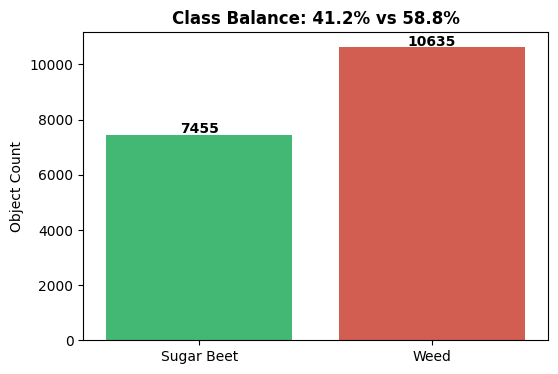


⚙️ Processing 2000 files...
✅ DONE! Train: 1600, Val: 400


In [6]:
# --- BLOCK 4: PROCESS XMLs (CLEAN + PNG ONLY + VISUAL GRAPH) ---

# 1. Configuration
TARGET_TOTAL_IMAGES = 2000
MIN_PCT = 40.0  # Balance range: 40-60%
MAX_ATTEMPTS = 20
output_dir = "yolo_seg_dataset"

# Class Mapping
CLASS_MAPPING = {
    "sugar_beet": 0,
    "weed": 1
}

# 2. Gather XML files
if 'dataset_path' not in locals():
    print("❌ ERROR: 'dataset_path' is missing.")
else:
    all_xml_files = glob.glob(os.path.join(dataset_path, "**", "*.xml"), recursive=True)

    selected_files = []

    # ==========================================
    # ⚖️ BALANCING LOOP
    # ==========================================
    print(f"\n🎲 Searching for a balanced dataset (Target: {TARGET_TOTAL_IMAGES})...")

    for attempt in range(1, MAX_ATTEMPTS + 1):
        random.seed(attempt * 100)
        random.shuffle(all_xml_files)
        current_selection = all_xml_files[:TARGET_TOTAL_IMAGES]

        counts = {"Sugar Beet": 0, "Weed": 0}

        for xml_file in current_selection:
            try:
                tree = ET.parse(xml_file)
                root = tree.getroot()
                for obj in root.iter('object'):
                    name = obj.find('name').text.lower()
                    if name == "sugar_beet": counts["Sugar Beet"] += 1
                    elif name == "weed": counts["Weed"] += 1
            except: pass

        total = sum(counts.values())
        if total == 0: continue

        beet_pct = (counts['Sugar Beet'] / total) * 100
        weed_pct = (counts['Weed'] / total) * 100

        if beet_pct >= MIN_PCT and weed_pct >= MIN_PCT:
            print(f"✅ Attempt {attempt}: Balanced! ({beet_pct:.1f}% vs {weed_pct:.1f}%)")
            selected_files = current_selection
            break

    if not selected_files:
        print("⚠️ Using last selection.")
        selected_files = current_selection

    # ==========================================
    # 📊 VISUALIZATION

    print("\n" + "="*40)
    print(f"🏆 FINAL DATASET: {len(selected_files)} Images")
    print(f"• Sugar Beet: {counts['Sugar Beet']} ({beet_pct:.1f}%)")
    print(f"• Weed:       {counts['Weed']} ({weed_pct:.1f}%)")
    print("="*40)

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=['#2ecc71', '#e74c3c'])
    plt.title(f"Class Balance: {beet_pct:.1f}% vs {weed_pct:.1f}%", fontsize=12, fontweight='bold')
    plt.ylabel("Object Count")

    # Add numbers on top of bars
    for i, v in enumerate(counts.values()):
        ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
    plt.show()

    # ==========================================
    # ⚙️ CONVERT & COPY (PNG DIRECT)
    # ==========================================
    split_idx = int(len(selected_files) * 0.8)
    splits = {"train": selected_files[:split_idx], "val": selected_files[split_idx:]}

    if os.path.exists(output_dir): shutil.rmtree(output_dir)

    for split in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

    print(f"\n⚙️ Processing {len(selected_files)} files...")
    file_counters = {"train": 0, "val": 0}

    for split_name, files_list in splits.items():
        for xml_file in files_list:
            try:
                tree = ET.parse(xml_file)
                root = tree.getroot()

                size = root.find('size')
                w = int(size.find('width').text)
                h = int(size.find('height').text)
                if w == 0 or h == 0: continue

                label_lines = []
                has_valid_object = False

                for obj in root.iter('object'):
                    cls_name = obj.find('name').text.lower()
                    if cls_name in CLASS_MAPPING:
                        cid = CLASS_MAPPING[cls_name]
                        bnd = obj.find('bndbox')
                        box = (float(bnd.find('xmin').text), float(bnd.find('ymin').text),
                               float(bnd.find('xmax').text), float(bnd.find('ymax').text))

                        # Box to Polygon Logic
                        dw = 1. / w
                        dh = 1. / h
                        p1 = f"{box[0]*dw:.6f} {box[1]*dh:.6f}"
                        p2 = f"{box[2]*dw:.6f} {box[1]*dh:.6f}"
                        p3 = f"{box[2]*dw:.6f} {box[3]*dh:.6f}"
                        p4 = f"{box[0]*dw:.6f} {box[3]*dh:.6f}"

                        label_lines.append(f"{cid} {p1} {p2} {p3} {p4}")
                        has_valid_object = True

                if has_valid_object:
                    base_path = os.path.splitext(xml_file)[0]
                    img_src = base_path + ".png"  # 👈 DIRECT PNG CHECK

                    if os.path.exists(img_src):
                        fname = os.path.basename(base_path)
                        with open(os.path.join(output_dir, "labels", split_name, fname + ".txt"), "w") as f:
                            f.write("\n".join(label_lines))
                        shutil.copy(img_src, os.path.join(output_dir, "images", split_name, os.path.basename(img_src)))
                        file_counters[split_name] += 1
            except: pass

    print(f"✅ DONE! Train: {file_counters['train']}, Val: {file_counters['val']}")

**Block 5: YAML Configuration Creation**

Generates the data_seg.yaml file required by YOLO to locate the dataset. It defines the absolute paths for training and validation directories and maps the integer class IDs (0, 1) to their corresponding names ('Sugar Beet', 'Weed').

In [7]:
# --- BLOCK 5: CREATE YAML CONFIGURATION ---

# 1. Define YAML content
yaml_content = {
    'path': os.path.abspath(output_dir), # Absolute path to 'yolo_seg_dataset'
    'train': 'images/train',
    'val': 'images/val',
    'names': {
        0: 'Sugar Beet',
        1: 'Weed'
    }
}

# 2. Save to file
yaml_path = os.path.join(output_dir, 'data_seg.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"✅ YOLO Segmentation config saved to: {yaml_path}")
print("📄 Config Content:")
print(yaml.dump(yaml_content, default_flow_style=False))

✅ YOLO Segmentation config saved to: yolo_seg_dataset/data_seg.yaml
📄 Config Content:
names:
  0: Sugar Beet
  1: Weed
path: /content/yolo_seg_dataset
train: images/train
val: images/val



# **Train YOLO model**

**Block 6: Optimized Training (Large Model & Aggressive Augmentation)**

Executes an advanced training pipeline aimed at maximizing accuracy (>80%). Key upgrades:

Model Upgrade: Switched to YOLO11-Large (smarter feature extraction) with a reduced batch size (4) to fit memory.

Extended Patience: Increased early stopping patience to 40 epochs to prevent premature stops.

Plant-Specific Augmentations: Added rotation (degrees=25) and vertical flips (flipud=0.5), as plants have no fixed orientation.

Mounted at /content/drive
✅ GPU Detected: Tesla T4
♻️ Found checkpoint at /content/drive/MyDrive/image_pros/yolo_seg_output/train_run_balanced_final/weights/last.pt! Resuming training...

🔄 Starting Training (High Accuracy Mode)...
⚡ Config: Batch=4 (Safe for Large), Epochs=100, Patience=40
Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo_seg_dataset/data_seg.yaml, degrees=25.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.

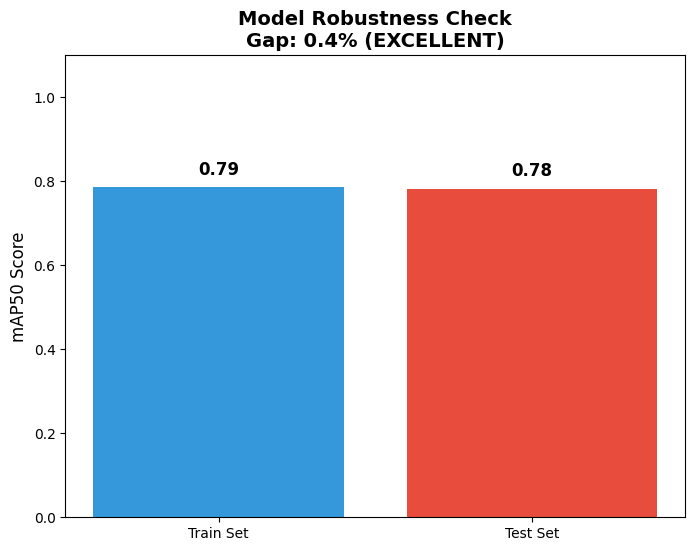


✅ Log saved to Drive: /content/drive/MyDrive/image_pros/experiment_history_log.csv
✅ Graph saved to Drive: /content/drive/MyDrive/image_pros/results_LARGE_20260119_1356.png


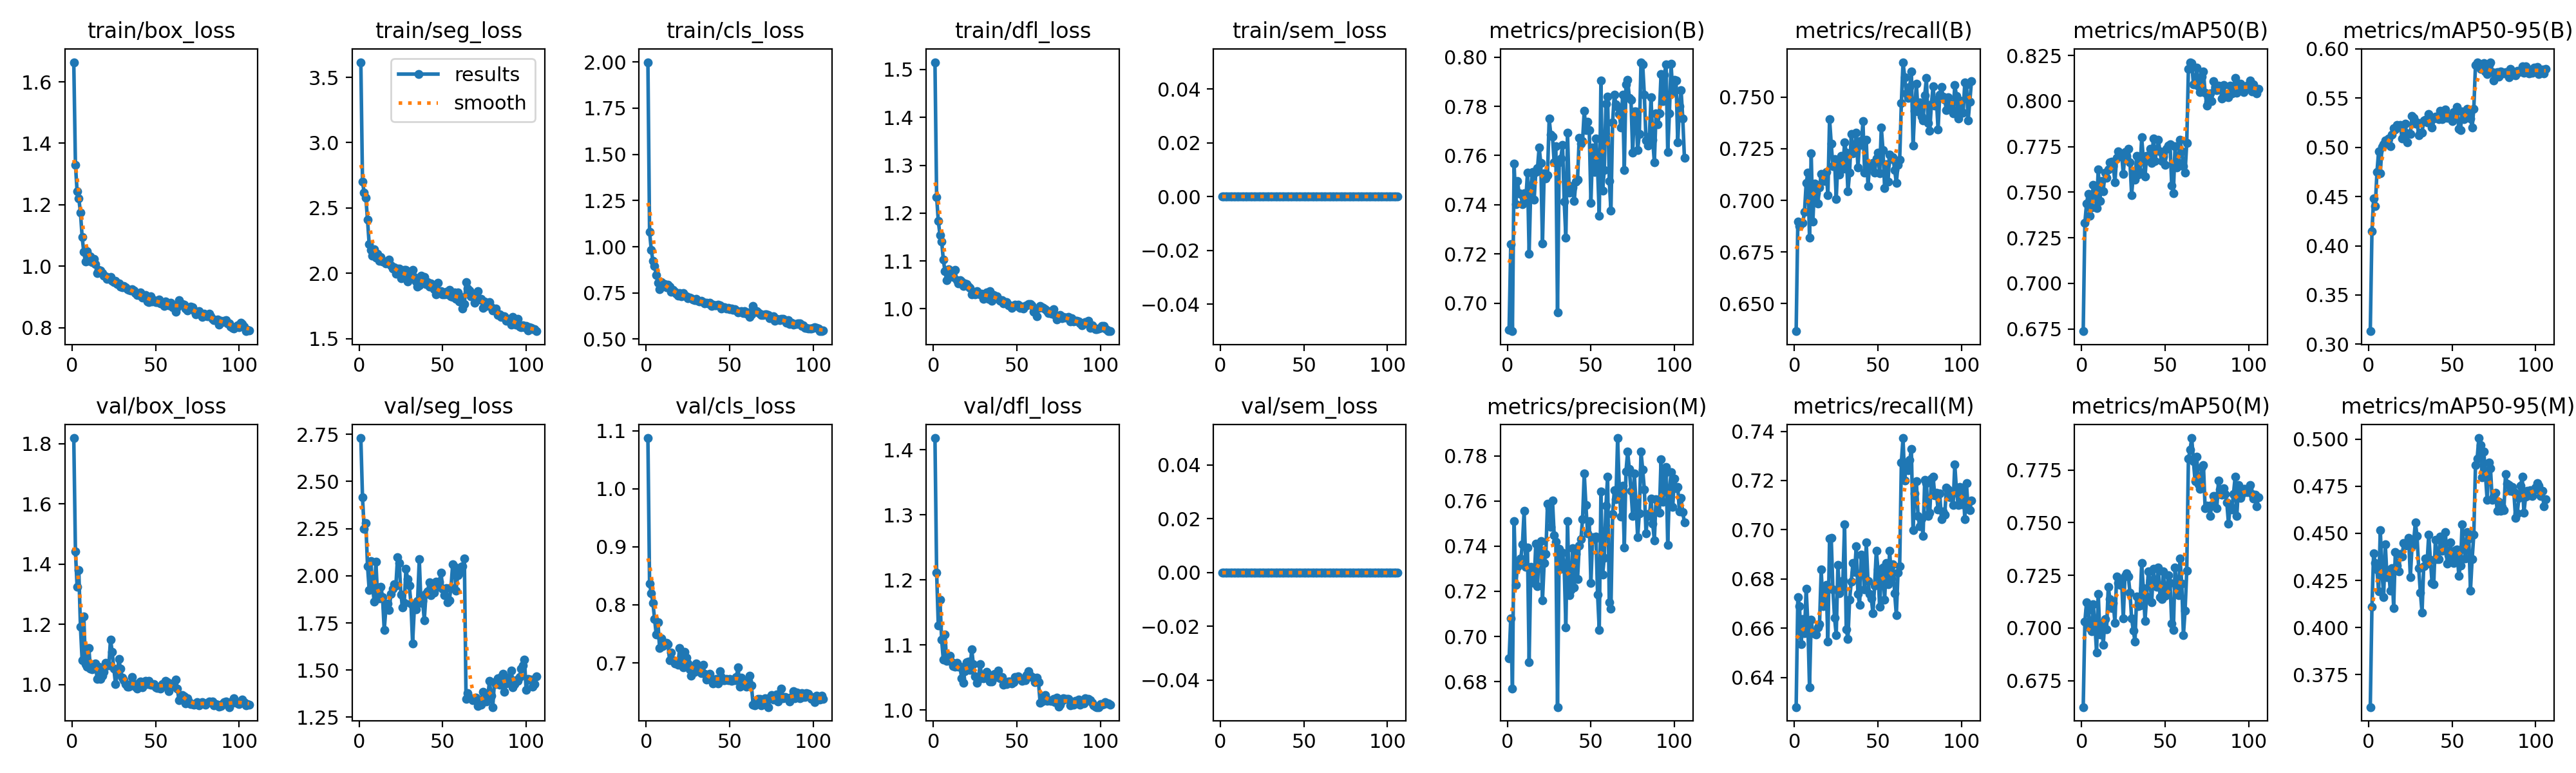

In [8]:
# --- BLOCK 6
# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Paths
drive_project_path = '/content/drive/MyDrive/image_pros/yolo_seg_output'
checkpoint_path = f"{drive_project_path}/train_run_balanced_final/weights/last.pt"

# --- BLOCK 5 (YOLO): TRAIN (PRO VERSION - LARGE MODEL) ---

# 1. GPU Check
if torch.cuda.is_available():
    device = 0
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
    use_amp = True
else:
    device = 'cpu'
    print("⚠️ WARNING: No GPU detected. Training will be slow.")
    use_amp = False

# 2. Load LARGE Model (Upgrade for better accuracy)
resume_mode = False

if os.path.exists(checkpoint_path):
    print(f"♻️ Found checkpoint at {checkpoint_path}! Resuming training...")
    model = YOLO(checkpoint_path)
    resume_mode = True
else:
    try:
        # CHANGED: Switched to 'l' (Large) model for higher accuracy
        print("🚀 Loading YOLO11-LARGE-Seg model (Targeting 80%+ Accuracy)...")
        model = YOLO('yolo11l-seg.pt')
    except:
        print("⚠️ YOLO11 not found, falling back to YOLOv8-Large.")
        model = YOLO('yolov8l-seg.pt')

# 3. Run Training (Aggressive Config)
print("\n🔄 Starting Training (High Accuracy Mode)...")
print("⚡ Config: Batch=4 (Safe for Large), Epochs=100, Patience=40")

results = model.train(
    data='yolo_seg_dataset/data_seg.yaml',
    epochs=100,             # INCREASED: Give it more time to learn
    imgsz=960,              # High resolution
    batch=4,                # DECREASED: To fit Large model in T4 GPU memory
    patience=40,            # INCREASED: Don't stop early! Let it struggle and improve
    project=drive_project_path,
    name='train_run_balanced_final',
    resume=resume_mode,
    device=device,
    verbose=True,
    workers=2,

    # --- Aggressive Augmentations for Plants ---
    augment=True,
    degrees=25.0,           # NEW: Rotates images +/- 25 degrees (Crucial for plants)
    fliplr=0.5,             # Flip Left-Right
    flipud=0.5,             # NEW: Flip Up-Down (Plants don't have a fixed 'up')
    scale=0.6,              # INCREASED: Zoom in/out more to handle size variety
    mosaic=1.0,             # Force Mosaic on
    mixup=0.15,             # INCREASED: Blends images slightly more
    copy_paste=0.3,         # INCREASED: Pastes objects on other backgrounds

    # Optimizer settings
    cache=True,
    amp=use_amp,
    cos_lr=True,
    close_mosaic=20,        # Stop mosaic augmentation closer to the end
    optimizer='auto'
)

# ==================================================
# ⚖️ OVERFITTING ANALYSIS (TRAIN vs. TEST)
# ==================================================
print("\n" + "="*40)
print("🧐 PERFORMING TRAIN vs. TEST COMPARISON...")

# A. Evaluate on VALIDATION set
print("1️⃣ Evaluating on VALIDATION set (Test)...")
metrics_val = model.val(split='val')
score_val = metrics_val.seg.map50

# B. Evaluate on TRAINING set
print("2️⃣ Evaluating on TRAINING set (Train)...")
metrics_train = model.val(split='train')
score_train = metrics_train.seg.map50

# C. Calculate Gap
gap = score_train - score_val
gap_pct = gap * 100

if gap < 0.10:
    status = "EXCELLENT"
elif gap < 0.20:
    status = "GOOD"
else:
    status = "OVERFITTING"

print("\n" + "="*40)
print(f"📊 TRAIN vs. TEST RESULTS (Large Model)")
print(f"• Train Score: {score_train:.4f}")
print(f"• Test Score:  {score_val:.4f}")
print(f"• Gap:         {gap_pct:.1f}% ({status})")
print("="*40)

# Visualize Gap
plt.figure(figsize=(8, 6))
colors = ['#3498db', '#e74c3c']
bars = plt.bar(['Train Set', 'Test Set'], [score_train, score_val], color=colors)
plt.title(f"Model Robustness Check\nGap: {gap_pct:.1f}% ({status})", fontsize=14, fontweight='bold')
plt.ylabel("mAP50 Score", fontsize=12)
plt.ylim(0, 1.1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.show()

# ==================================================
# 💾 LOGGING RESULTS TO GOOGLE DRIVE
# ==================================================
drive_folder = '/content/drive/MyDrive/image_pros'
log_file = os.path.join(drive_folder, 'experiment_history_log.csv')

os.makedirs(drive_folder, exist_ok=True)
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

row_data = [
    current_time,
    'YOLO11-Large',                # Updated Name
    100,                           # Updated Epochs
    960,
    round(score_val, 4),
    round(score_train, 4),
    round(gap_pct, 2),
    status,
    metrics_val.results_dict['metrics/precision(M)'],
    metrics_val.results_dict['metrics/recall(M)']
]

headers = ['Timestamp', 'Model', 'Epochs', 'ImgSz', 'Test_mAP50', 'Train_mAP50', 'Gap_Pct', 'Status', 'Precision', 'Recall']

file_exists = os.path.isfile(log_file)
try:
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)
        writer.writerow(row_data)
    print(f"\n✅ Log saved to Drive: {log_file}")
except Exception as e:
    print(f"\n❌ Error saving log to Drive: {e}")

# Save Graph
try:
    graph_src = f"{drive_project_path}/train_run_balanced_final/results.png"
    if os.path.exists(graph_src):
        timestamp_str = datetime.now().strftime("%Y%m%d_%H%M")
        graph_dst = os.path.join(drive_folder, f"results_LARGE_{timestamp_str}.png")
        shutil.copy(graph_src, graph_dst)
        print(f"✅ Graph saved to Drive: {graph_dst}")
        display(Image(filename=graph_src))
except Exception as e:
    print(f"⚠️ Could not save graph to drive: {e}")

**Block 7: Selective High-Confidence Inference**

Iterates through the validation dataset to find and display exactly 3 images where the model detects objects with high certainty (>80%). It automatically skips images with no detections or low confidence scores to ensure only meaningful results are visualized.

📸 Scanning 400 images to find 3 valid detections (>80% confidence)...
✅ Image 1/3 found! (near30_near30_21_05_2021_v_5_4.png)


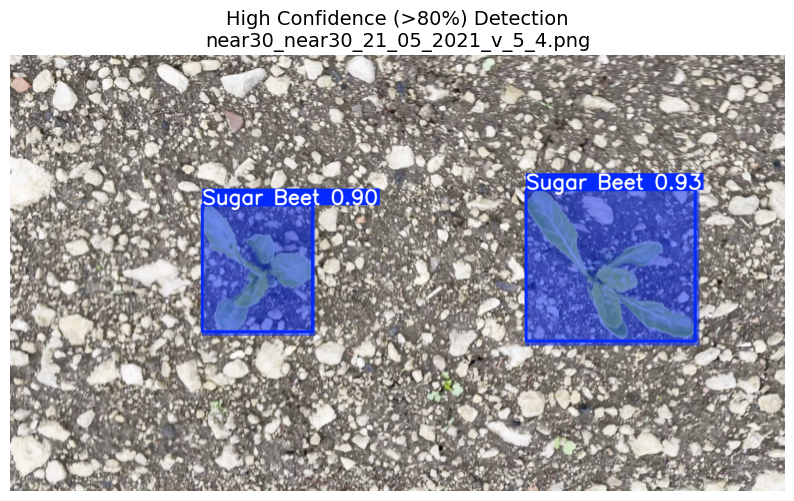

✅ Image 2/3 found! (near30_near30_01_06_2021_v_5_26.png)


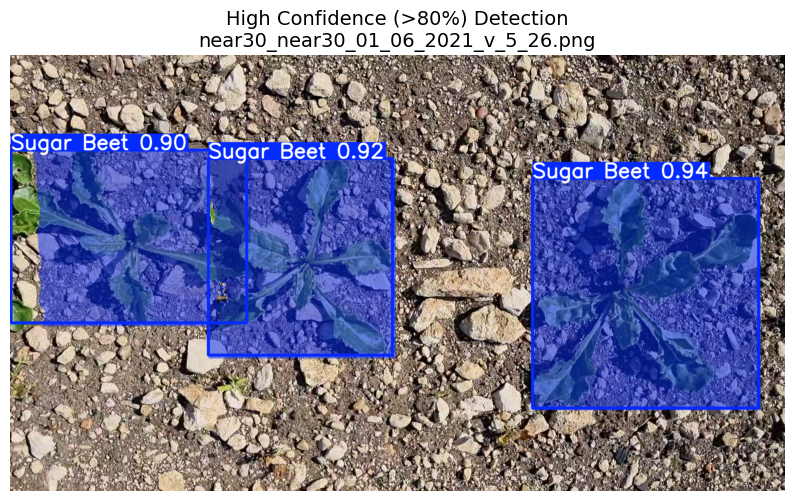

✅ Image 3/3 found! (near30_near30_01_06_2021_v_3_225.png)


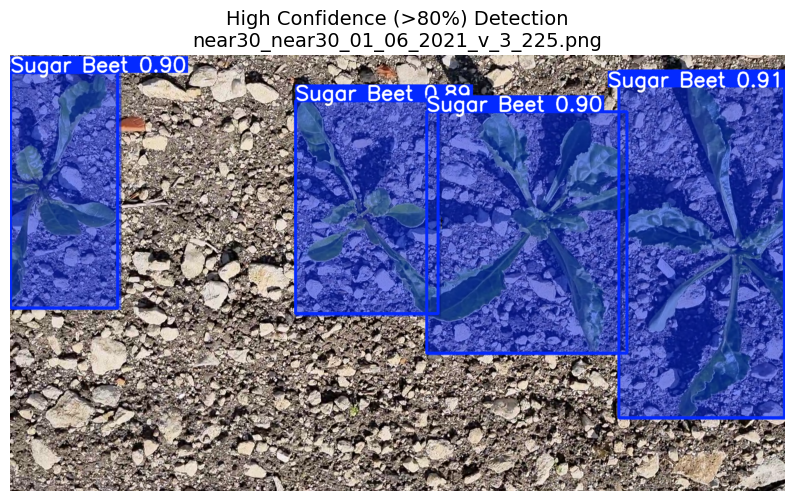

In [10]:
# --- BLOCK 7: PREDICT & SHOW ONLY HIGH CONFIDENCE IMAGES (>80%)-----------------------
# 1. Search for images in validation folder
search_path_png = 'yolo_seg_dataset/images/val/*.png'
search_path_jpg = 'yolo_seg_dataset/images/val/*.jpg'

images_list = glob.glob(search_path_png) + glob.glob(search_path_jpg)

# Shuffle the list to get different images on every run
random.shuffle(images_list)

# Safety check: Ensure images exist
if len(images_list) == 0:
    print("❌ Error: No images found in 'yolo_seg_dataset/images/val/'. Check your dataset path.")
else:
    print(f"📸 Scanning {len(images_list)} images to find 3 valid detections (>80% confidence)...")

    found_count = 0
    target_count = 3

    # 2. Loop through images until we find 3 good examples
    for img_path in images_list:
        if found_count >= target_count:
            break  # Stop once we have 3 images

        # Run inference on a single image
        # conf=0.8: Only detect if confidence is > 80%
        # verbose=False: Suppress console output for cleaner logs
        results = model.predict(source=img_path, conf=0.8, save=False, verbose=False)
        r = results[0]

        # 3. Check if any objects were detected
        if len(r.boxes) > 0:
            found_count += 1
            print(f"✅ Image {found_count}/{target_count} found! ({os.path.basename(img_path)})")

            # 4. Plot and Display Result
            im_array = r.plot() # Returns BGR numpy array
            im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB) # Convert to RGB

            plt.figure(figsize=(10, 8))
            plt.imshow(im_rgb)
            plt.axis('off')
            plt.title(f"High Confidence (>80%) Detection\n{os.path.basename(img_path)}", fontsize=14)
            plt.show()

    # Report if no high-confidence images were found
    if found_count == 0:
        print("\n⚠️ Warning: Scanned images but found NO detections with >80% confidence.")
        print("   Try lowering the confidence threshold (e.g., conf=0.5 or 0.25).")
    elif found_count < target_count:
        print(f"\n⚠️ Note: Only found {found_count} images matching the criteria.")

#**Block 8: Final Head-to-Head Comparison**

Aggregates results from both pipelines to perform a direct quantitative comparison. It generates a summary table and a bar chart to visualize the performance gap between the Classical approach (IoU) and the YOLO model (mAP50), determining the final winner based on accuracy scores.


🏆 FINAL SHOWDOWN: CLASSICAL vs. YOLO 🏆

📋 QUANTITATIVE RESULTS TABLE:


Method                     Score Type  Score Value  \
0        Classical (Otsu/ExG)           IoU (Pixel Accuracy)     0.228617   
1  Deep Learning (YOLO11-Seg)  mAP50 (Segmentation Accuracy)     0.782110   

                 Speed                Robustness  
0           Fast (CPU)  Low (Sensitive to light)  
1  Fast (GPU Required)   High (Learned Features)

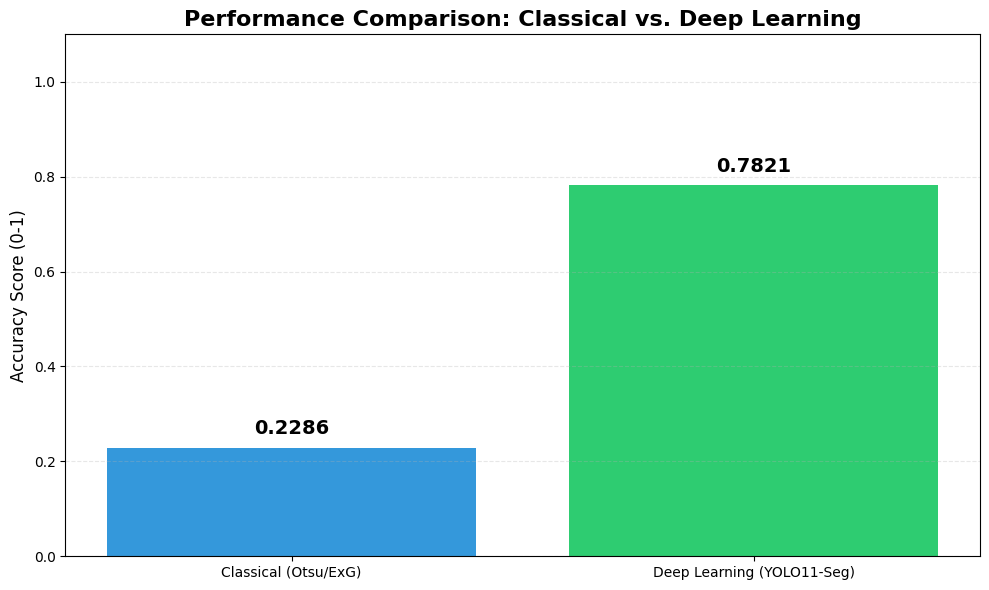


📢 CONCLUSION:
The YOLO11 model won by 55.3%!
This demonstrates the power of Deep Learning in handling complex segmentation tasks.


In [15]:
# --- BLOCK 8 (FINAL): HEAD-TO-HEAD COMPARISON (CLEAN) ---

print("\n🏆 FINAL SHOWDOWN: CLASSICAL vs. YOLO 🏆")

# 1. Gather Scores
# FIX: Adjusted variable names to match previous blocks exactly.

# Classical Score: 'iou' from Block 5 (Classical)
classic_score = iou if 'iou' in locals() else 0.0

# YOLO Score: 'score_val' from Block 5 (YOLO)
# We prioritize 'score_val' because it was explicitly calculated in Block 5.
if 'score_val' in locals():
    yolo_score = score_val
elif 'metrics_val' in locals():
    yolo_score = metrics_val.seg.map50
else:
    yolo_score = 0.0

# 2. Create Comparison Table
comparison_data = {
    "Method": ["Classical (Otsu/ExG)", "Deep Learning (YOLO11-Seg)"],
    "Score Type": ["IoU (Pixel Accuracy)", "mAP50 (Segmentation Accuracy)"],
    "Score Value": [classic_score, yolo_score],
    "Speed": ["Fast (CPU)", "Fast (GPU Required)"],
    "Robustness": ["Low (Sensitive to light)", "High (Learned Features)"]
}

df_compare = pd.DataFrame(comparison_data)

print("\n📋 QUANTITATIVE RESULTS TABLE:")
# 'display()' works automatically in Colab/Jupyter for nice tables
try:
    display(df_compare)
except NameError:
    print(df_compare) # Fallback for standard python scripts

# 3. Generate Comparison Bar Chart
plt.figure(figsize=(10, 6))
# Create bar plot
bars = plt.bar(df_compare["Method"], df_compare["Score Value"], color=['#3498db', '#2ecc71'])

# Design
plt.title("Performance Comparison: Classical vs. Deep Learning", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy Score (0-1)", fontsize=12)
plt.ylim(0, 1.1) # Scale from 0 to 1.1 to make room for labels
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Show
plt.tight_layout()
plt.show()

# 4. Final Conclusion Print
if yolo_score > classic_score:
    winner = "YOLO11"
    gap = (yolo_score - classic_score) * 100
    conclusion_text = f"The {winner} model won by {gap:.1f}%!\nThis demonstrates the power of Deep Learning in handling complex segmentation tasks."
elif classic_score > yolo_score:
    winner = "Classical"
    gap = (classic_score - yolo_score) * 100
    conclusion_text = f"Surprisingly, the Classical method won by {gap:.1f}%.\nThis might be due to simple backgrounds or a lack of training epochs for YOLO."
else:
    winner = "Tie"
    conclusion_text = "It's a Tie! Both methods performed equally."

print(f"\n📢 CONCLUSION:")
print(conclusion_text)